# Filter for pairwise retrosynthesizability

## Aim of this notebook

This notebook is filtering the fragments for pairwise retrosynthesizability using the web API from [ASKCOS](https://askcos.mit.edu/).

We build all valid fragment pairs and look if a retrosynthetic route can be found to create this pair from the fragments given. To reduce the number of requests we first apply all filters from the previous notebooks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Lipinski, PandasTools

from kinfraglib import filters, utils

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

## Globals

In [4]:
# Path to data
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

## 1. Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / 'fragment_library')

In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(7486, 15)

## 2. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library_pre_filtered = filters.prefilters.pre_filters(
    fragment_library)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]"
1,AP,N/C(=C1\C(=O)Nc2ccccc21)c1ccccc1,,,,AAK1,NAK,Other,5te0,XIN,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...,[12*]N/C(=C1\C(=O)Nc2cc([20*])ccc21)c1ccccc1,3,"[SE, GA]","[AP=SE, AP=GA]"
2,AP,Cc1cc(N)[nH]n1,,,,ABL1,Abl,TK,2f4j,VX6,,A,AP AP AP AP AP AP AP AP AP AP AP AP AP SE,5 5 14 14 14 14 14 14 14 8 8 8 8 na,[22*]Nc1cc(C)n[nH]1,9,[SE],[AP=SE]
3,AP,Nc1ncc(C=O)s1,,,,ABL1,Abl,TK,2gqg,1N1,B,A,AP AP AP AP AP AP AP AP AP AP GA SE,14 14 14 6 5 5 14 14 14 6 na na,[15*]Nc1ncc(C([41*])=O)s1,17,"[GA, SE]","[AP=GA, AP=SE]"
4,AP,COCC(=O)n1cc2[nH]nc(NC=O)c2c1,,,,ABL1,Abl,TK,2v7a,627,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,8 8 8 8 8 5 5 6 6 8 8 8 8 8 8 8 8 8 8 3 3 3 3 ...,[8*]C(=O)Nc1n[nH]c2cn(C(=O)[C@@H]([46*])OC)cc12,3,"[SE, FP]","[AP=SE, AP=FP]"

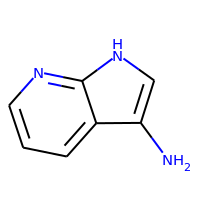
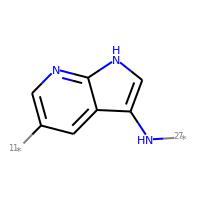
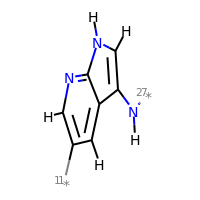
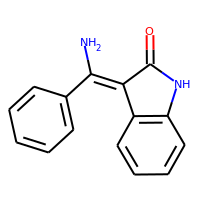
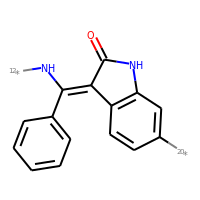
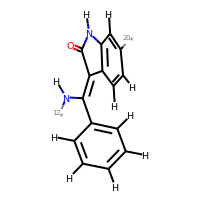
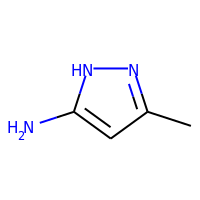
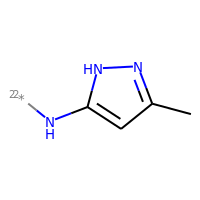
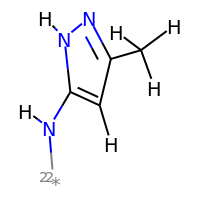
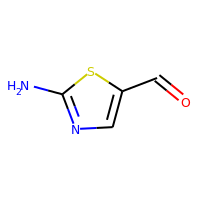
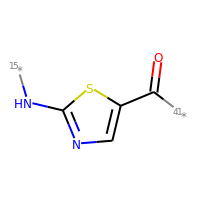
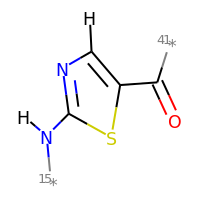
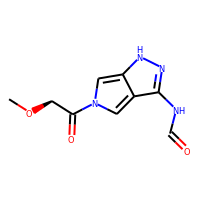
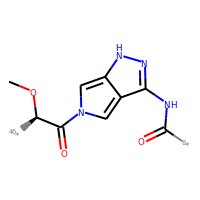
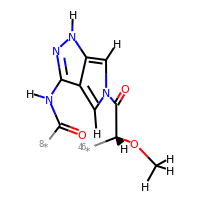

In [9]:
fragment_library_pre_filtered['AP'].head()

In [10]:
pd.concat([filters.analysis.count_fragments(fragment_library,
                                            'original'),
           filters.analysis.count_fragments(fragment_library_pre_filtered,
                                            'pre_filtered')],
          axis=1)
# NBVAL_CHECK_OUTPUT

,original,pre_filtered
subpocket,,
AP,2561,1001
FP,1866,864
SE,1560,607
GA,1024,306
B1,98,42
B2,92,42


For further use we save fragment_library as fragment_library_original and fragment_library_pre_filtered as fragment_library.

In [11]:
fragment_library_original = fragment_library.copy()
fragment_library = fragment_library_pre_filtered.copy()

## 3. Apply filters from notebooks

### 3.1. Filter for unwanted substructures

In [12]:
fragment_library, _ = filters.unwanted_substructures.get_pains(fragment_library)

In [13]:
HERE = Path(_dh[-1])
PATH_DATA_BRENK =  PATH_DATA / 'filters/Brenk'

In [14]:
fragment_library, brenk_structs = filters.unwanted_substructures.get_brenk(
    fragment_library, PATH_DATA_BRENK
)

Number of unwanted substructures in Brenk et al. collection: 104


### 3.2. Filter for druglikeness

Filter fragments for rule of three

In [15]:
fragment_library = filters.drug_likeness.get_ro3_frags(fragment_library)

Filter fragments for Quantitative Estimate of Druglikeness

In [16]:
fragment_library = filters.drug_likeness.get_qed(fragment_library, cutoff_val=0.492)

### 3.3. Filter for synthesizablilty

In [17]:
PATH_DATA_ENAMINE = HERE / "../../data/filters/DataWarrior"
fragment_library = filters.synthesizability.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA_ENAMINE) + "/Enamine_Building_Blocks.sdf"),
)

In [18]:
fragment_library = filters.synthesizability.calc_syba(fragment_library, cutoff=0)

In [19]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=['bool_pains', 'bool_brenk', 'bool_ro3', 'bool_qed', 'bool_bb', 'bool_syba'],
    min_accepted=6)
pd.concat(fragment_library).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(2862, 27)

In [20]:
pd.concat([filters.analysis.count_fragments(
    fragment_library,
    'pre_filtered'),      
           filters.analysis.count_accepted_rejected(
              fragment_library,
              'bool', 'filtered')],
          axis=1)
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_filtered,rejected_filtered
subpocket,,,
AP,1001,179,822
FP,864,156,708
SE,607,150,457
GA,306,96,210
B1,42,8,34
B2,42,18,24


Save fragments that fulfill all 6 filters to use them for the pairwise retrosynthesizability

In [21]:
for subpocket in fragment_library.keys():
    fragment_library[subpocket].drop(fragment_library[subpocket].loc[fragment_library[subpocket]['bool']==0].index, inplace=True)
    fragment_library[subpocket] = fragment_library[subpocket].reset_index(drop=True)
pd.concat(fragment_library).reset_index(drop=True).shape
# NBVAL_CHECK_OUTPUT

(607, 27)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,connections_name,bool_pains,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,"[AP=FP, AP=SE]",1,1,1,1,0.565900,1,1,30.950959,1
1,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,...,"[AP=SE, AP=GA]",1,1,1,1,0.511376,1,1,39.622898,1
2,AP,Nc1cc(C2CC2)[nH]n1,,,,ACTR2,STKR,TKL,3soc,GVD,...,[AP=SE],1,1,1,1,0.581756,1,1,18.524861,1
3,AP,Cc1c[nH]c2ncncc12,,,,AKT1,Akt,AGC,3mv5,XFE,...,[AP=FP],1,1,1,1,0.587513,1,1,18.452049,1
4,AP,c1ncc2cc[nH]c2n1,,,,AKT1,Akt,AGC,3ocb,XM1,...,[AP=FP],1,1,1,1,0.560736,1,1,30.638320,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,AP,Nc1ccnn1-c1ccccc1,,,,p38a,MAPK,CMGC,3ocg,OCG,...,[AP=GA],1,1,1,1,0.684047,1,1,33.489899,1
175,AP,O=c1[nH]cncc1Cl,,,,p38a,MAPK,CMGC,3roc,29A,...,"[AP=GA, AP=SE]",1,1,1,1,0.553490,1,1,20.051352,1
176,AP,O=C1CCCCc2ccccc21,,,,p38a,MAPK,CMGC,3uvp,048,...,[AP=GA],1,1,1,1,0.533002,1,1,30.415166,1
177,AP,c1coc(-c2nc[nH]n2)c1,,,,p38a,MAPK,CMGC,5xyx,FTZ,...,[AP=GA],1,1,1,1,0.635714,1,1,35.967668,1

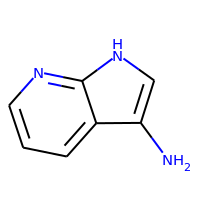
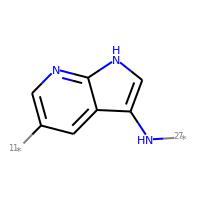
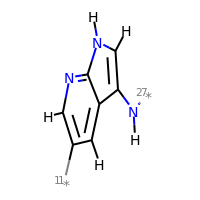
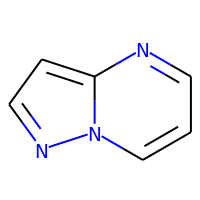
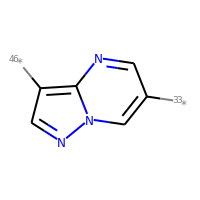
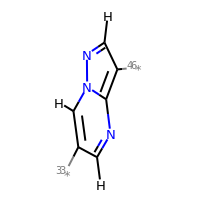
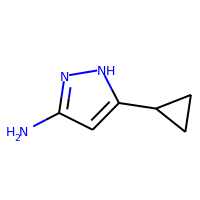
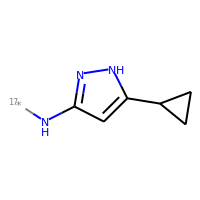
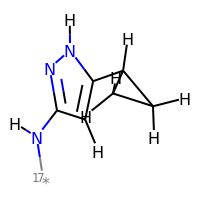
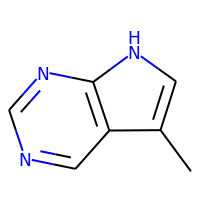
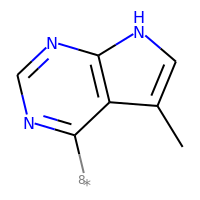
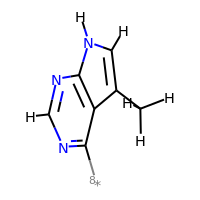
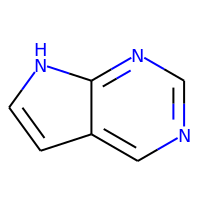
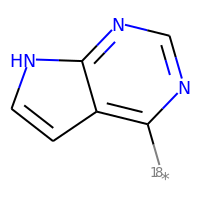
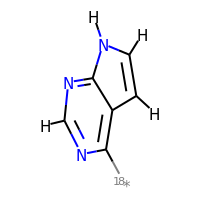
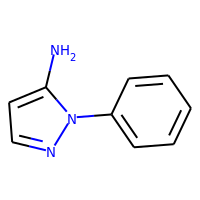
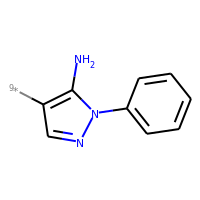
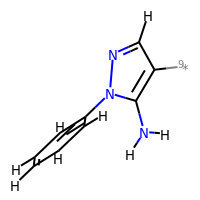
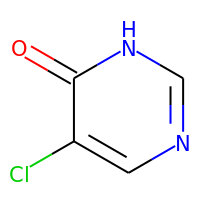
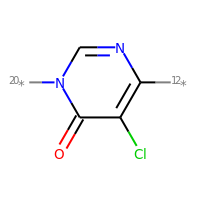
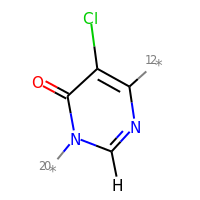
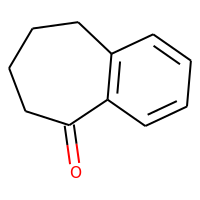
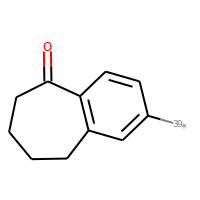
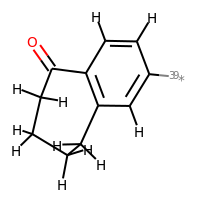
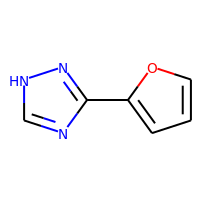
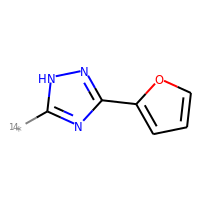
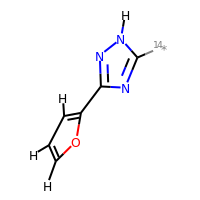
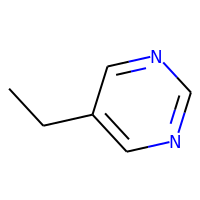
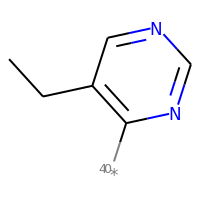
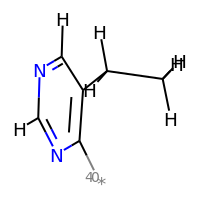

In [22]:
fragment_library['AP']

## 4. Pairwise retrosynthesizability

### 4.1. Get valid fragment pairs

In [23]:
valid_fragment_pairs, unique_pairs = filters.retro.get_valid_fragment_pairs(fragment_library)

Number of fragments:  607
Number of unique pairs: 27484


Note: valid_fragment_pairs contains also the duplicated pairs like [AP_0, SE_0] and [SE_0, AP_0]

### 4.2. Calculate retrosynthesizability for pairs
ASKCOS is used to check if for the fragment pairs a retrosynthetic route can be found. We exclude all fragments where no retrosynthetic route was found.

In [24]:
PATH_DATA_RETRO = HERE / '../../data/filters/retrosynthesizability'

ASKCOS query is started for fragments which where not already computed and children retrieved from ASKCOS get compared with the fragments building the pairs.
Depending on the number of new queries and molecule comparisons this could run a long time (query of 14943 pairs took ~1 Day on a 8 core machine).

Note: If your internet connection is instable you might need to run this several times. When starting it new it will only compute the pairs which were not yet computed.

In [25]:
%%time
warnings.filterwarnings("ignore")
fragment_library, countfrag, mol_df, diff_df = filters.retro.get_pairwise_retrosynthesizability(unique_pairs, PATH_DATA_RETRO, valid_fragment_pairs, fragment_library)

ASKCOS query started for 0 fragments.
ASKCOS query finished.
Comparing ASKCOS children with fragments..
Checking if all fragment pairs were requested..
All fragment pairs were requested.
Done.
CPU times: user 3min 44s, sys: 6.45 s, total: 3min 51s
Wall time: 5min 27s


Note: if not all fragment pairs were requested, please run this function again.

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,...,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool,retro_count,bool_retro
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,...,1,1,1,0.565900,1,1,30.950959,1,0,0
1,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,...,1,1,1,0.511376,1,1,39.622898,1,154,1
2,AP,Nc1cc(C2CC2)[nH]n1,,,,ACTR2,STKR,TKL,3soc,GVD,...,1,1,1,0.581756,1,1,18.524861,1,76,1

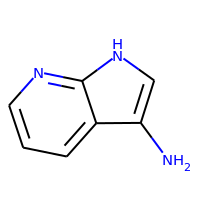
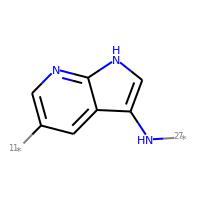
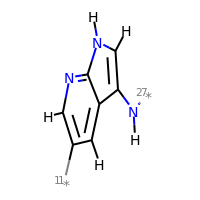
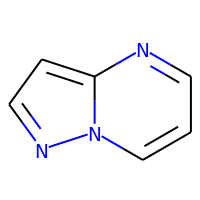
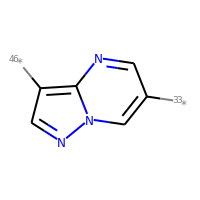
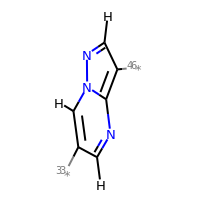
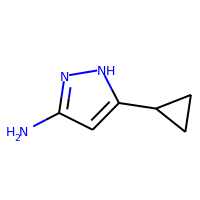
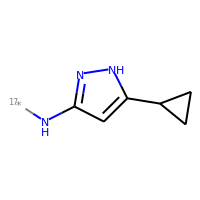
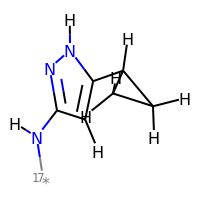

In [26]:
fragment_library['AP'].head(3)

,fragment ids,fragment 1,fragment 2,pair,child 1,child 2,plausibility
0,"[AP_1, SE_1]",,,,,,1
1,"[AP_1, SE_1]",,,,,,1
2,"[AP_1, SE_4]",,,,,,0.999733

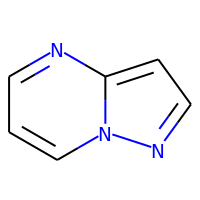
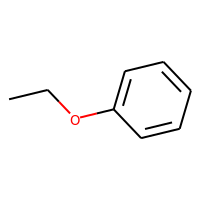
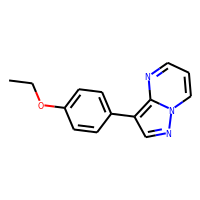
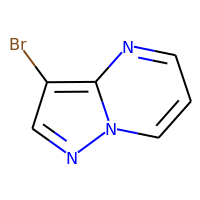
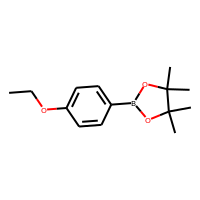
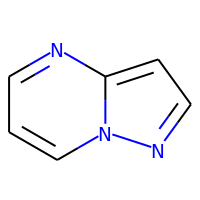
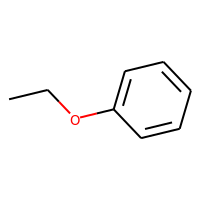
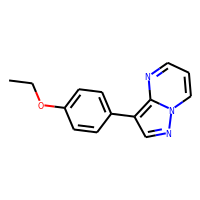
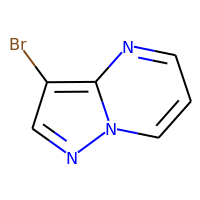
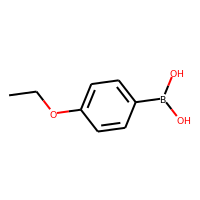
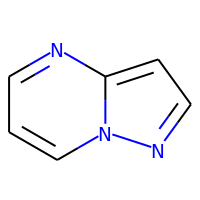
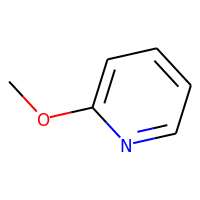
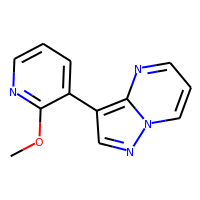
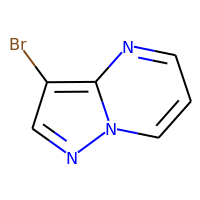
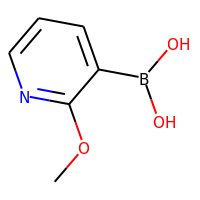

In [27]:
mol_df.head(3)

,fragment ids,fragment 1,fragment 2,pair,child 1,child 2,plausibility
0,"[AP_1, SE_43]",,,,,,0.999982
1,"[AP_1, GA_48]",,,,,,0.999981
2,"[AP_9, FP_0]",,,,,,0.940733

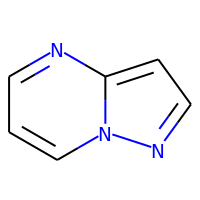
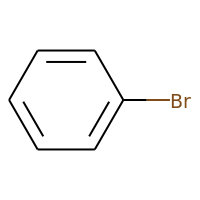
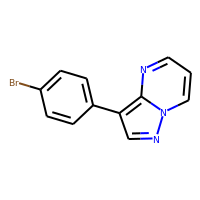
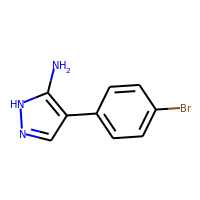
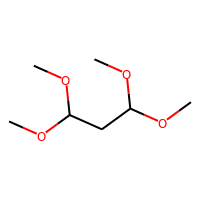
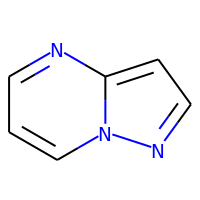
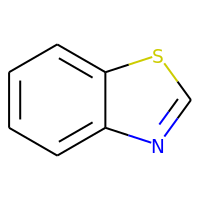
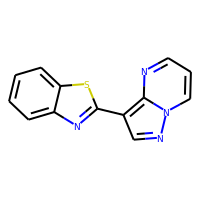
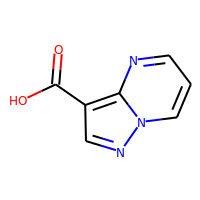
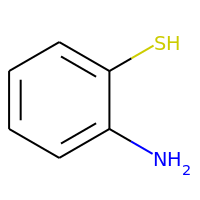
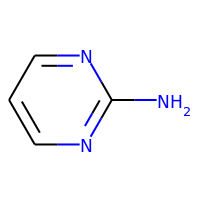
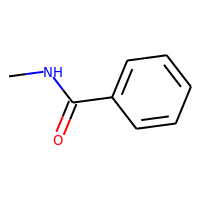
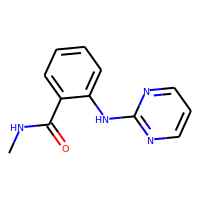
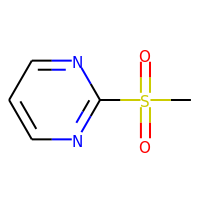
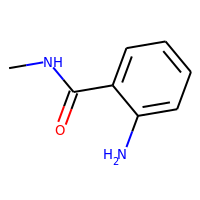

In [28]:
diff_df.head(3)

## 5. Analyse accepted/rejected fragments

### 5.1. Count number of fragments accepted by the filter
Count number of accepted and rejeceted fragments.

In [29]:
num_fragments_retro = pd.concat(
    [
        filters.analysis.count_fragments(
            fragment_library, "custom_filtered"
        ),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_retro", "pairwise_retosynthesizability"
        ),
    ],
    axis=1,
)
num_fragments_retro.append(num_fragments_retro.sum().rename('Total'))

,custom_filtered,accepted_pairwise_retosynthesizability,rejected_pairwise_retosynthesizability
subpocket,,,
AP,179,107,72
FP,156,97,59
SE,150,95,55
GA,96,79,17
B1,8,5,3
B2,18,5,13
Total,607,388,219


### 5.2. Plot number of retrosynthetic routes found for the fragments

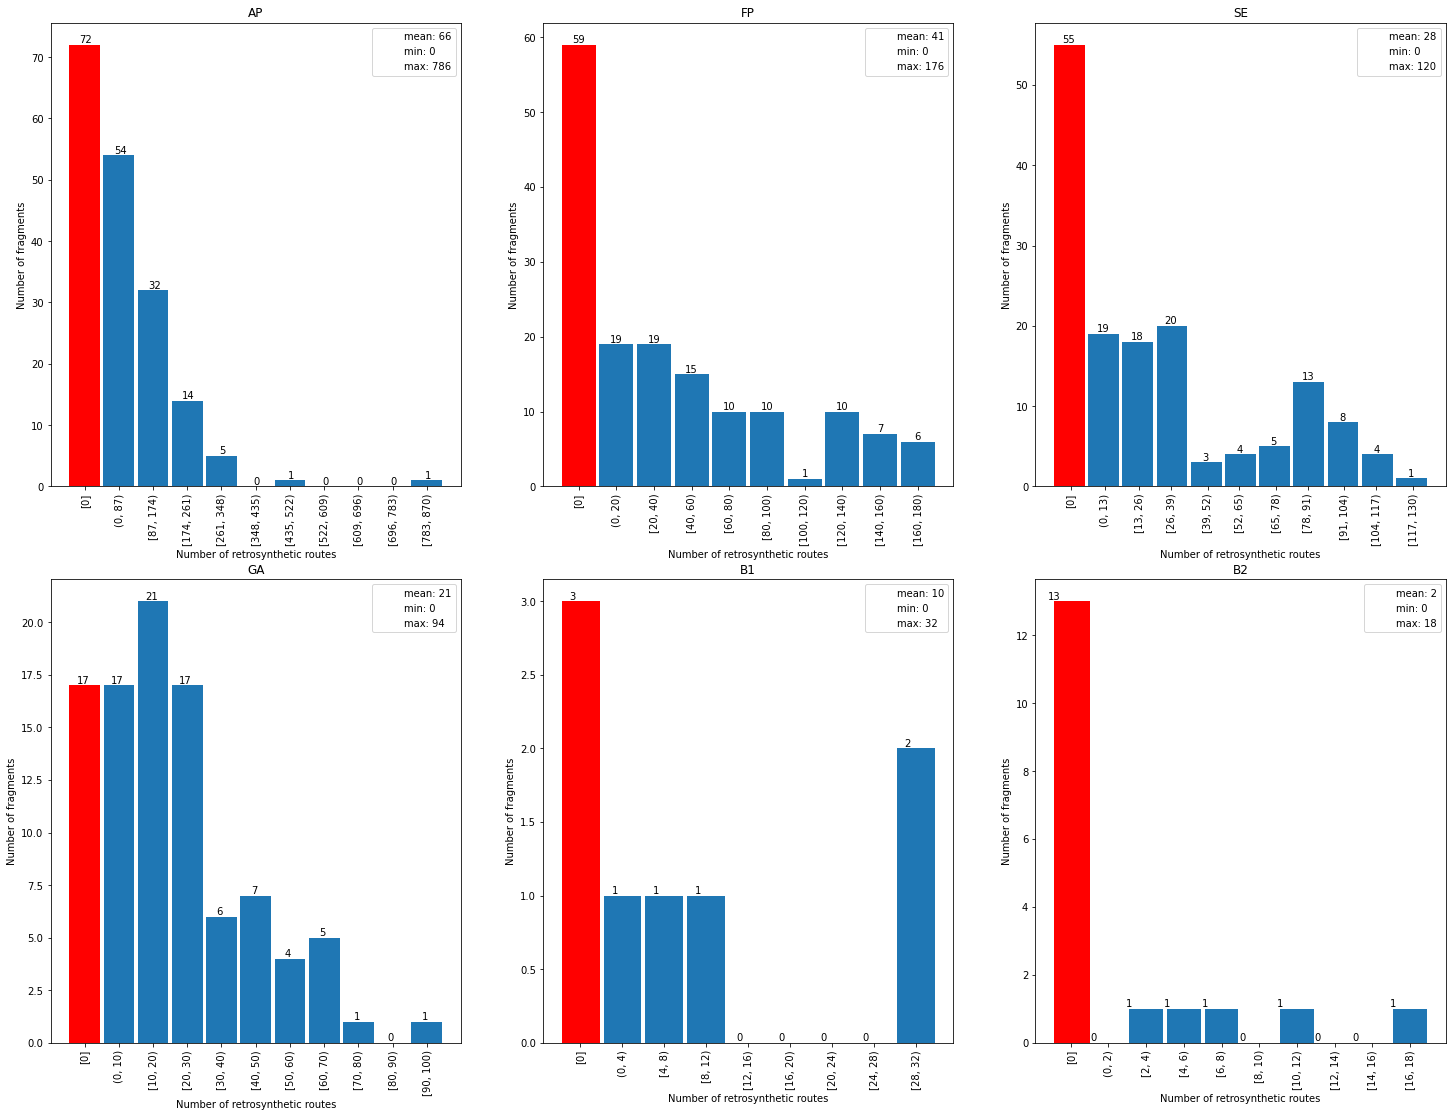

In [30]:
filters.retro.make_retro_hists(fragment_library, "retro_count", cutoff = 0)

### 5.3. look at some molecules without retrosynthetic route and  the one with the most retrosynthetic routes per subpocket

#### 5.3.1 Adenine Pocket (AP)

Accepted fragments

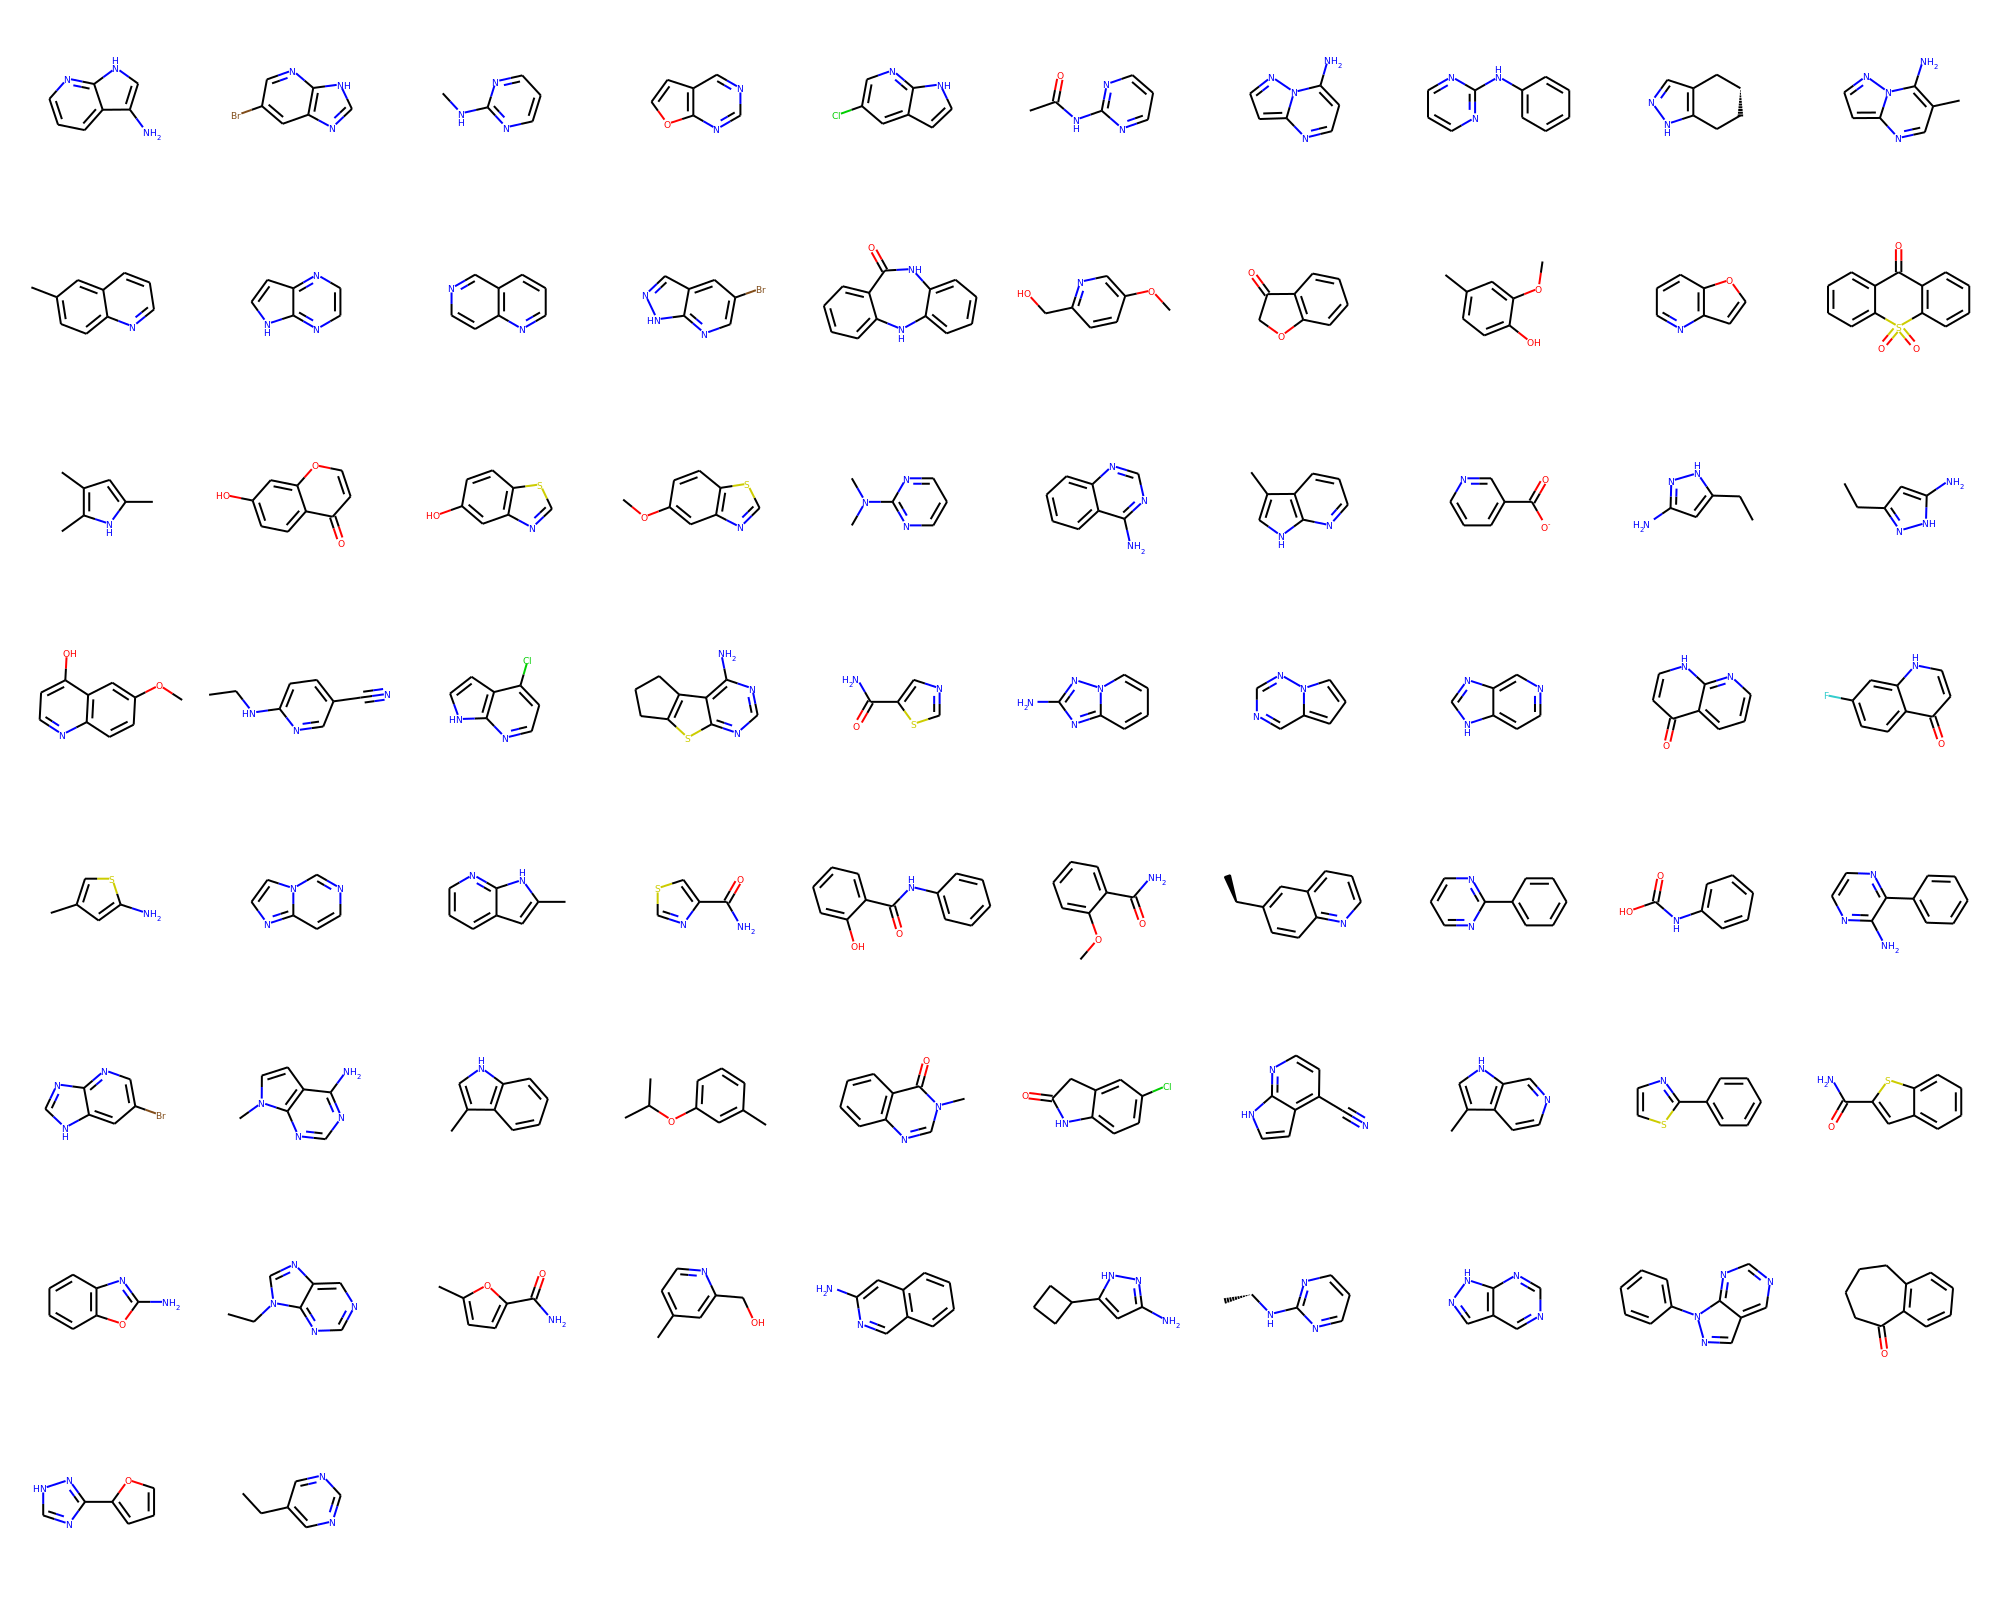

In [31]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["AP"][fragment_library["AP"]["retro_count"]==0].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["AP"][fragment_library["AP"]["retro_count"]==0].ROMol))
)

Rejected fragments

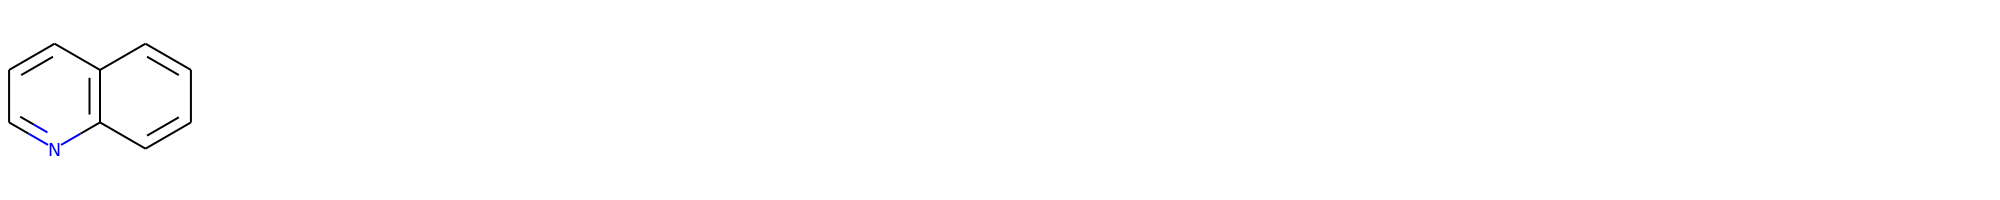

In [32]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["AP"][fragment_library["AP"]["retro_count"]==max(fragment_library["AP"]["retro_count"])].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["AP"][fragment_library["AP"]["retro_count"]==0].ROMol))
)

#### 5.3.2 Front Pocket (FP)

Accepted fragments

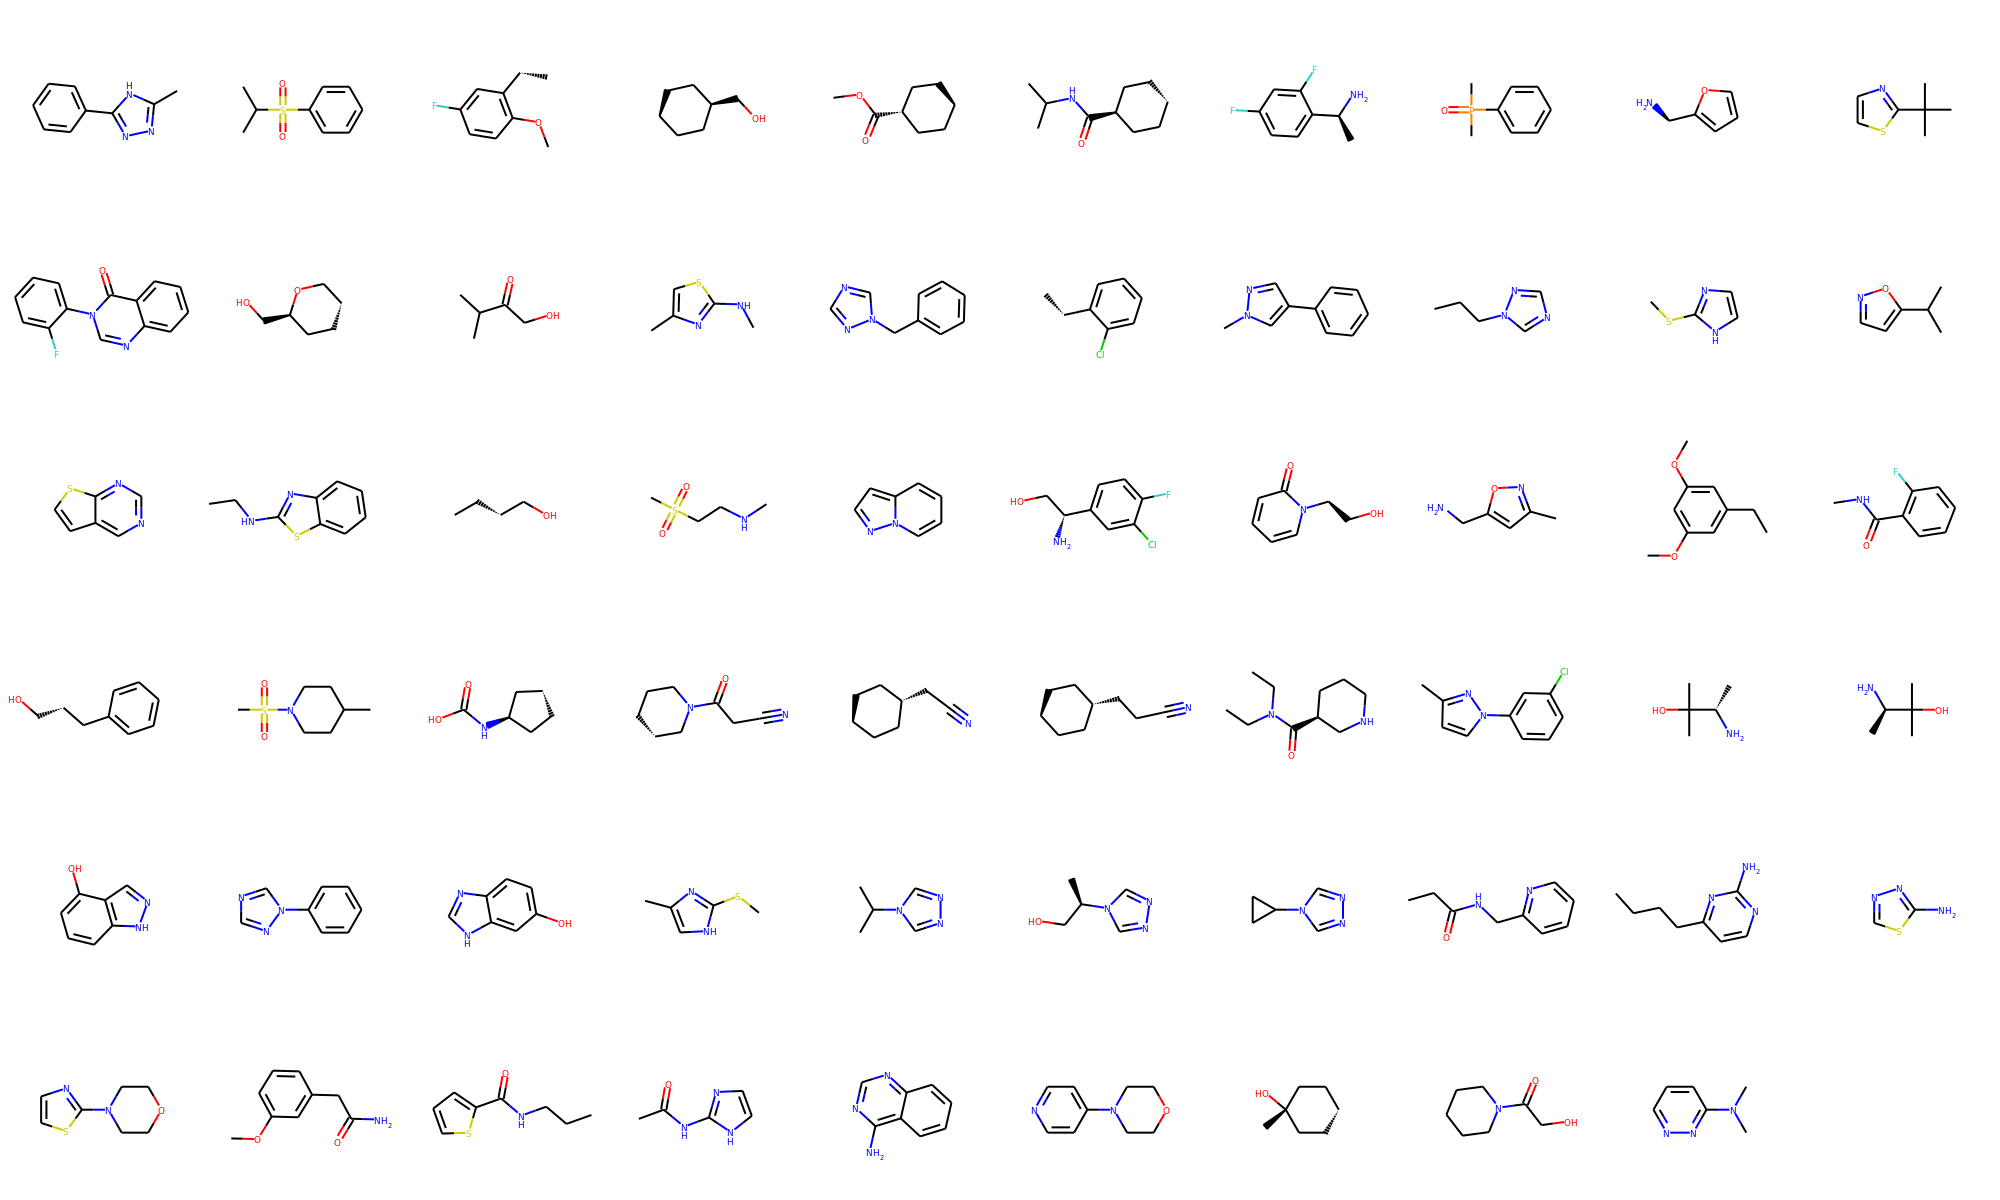

In [33]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["FP"][fragment_library["FP"]["retro_count"]==0].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["FP"][fragment_library["FP"]["retro_count"]==0].ROMol))
)

Rejected fragments

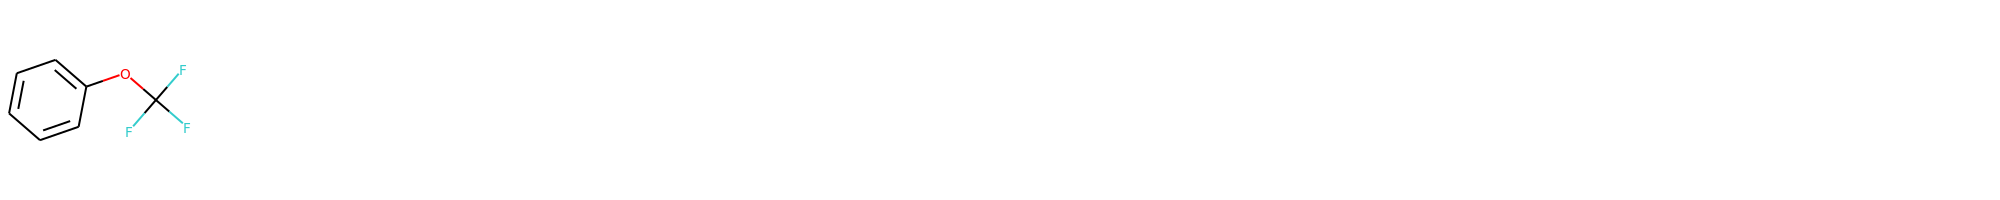

In [34]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["FP"][fragment_library["FP"]["retro_count"]==max(fragment_library["FP"]["retro_count"])].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["FP"][fragment_library["FP"]["retro_count"]==0].ROMol))
)

#### 5.3.3 Solvent Exposed Pocket (SE)

Accepted fragments

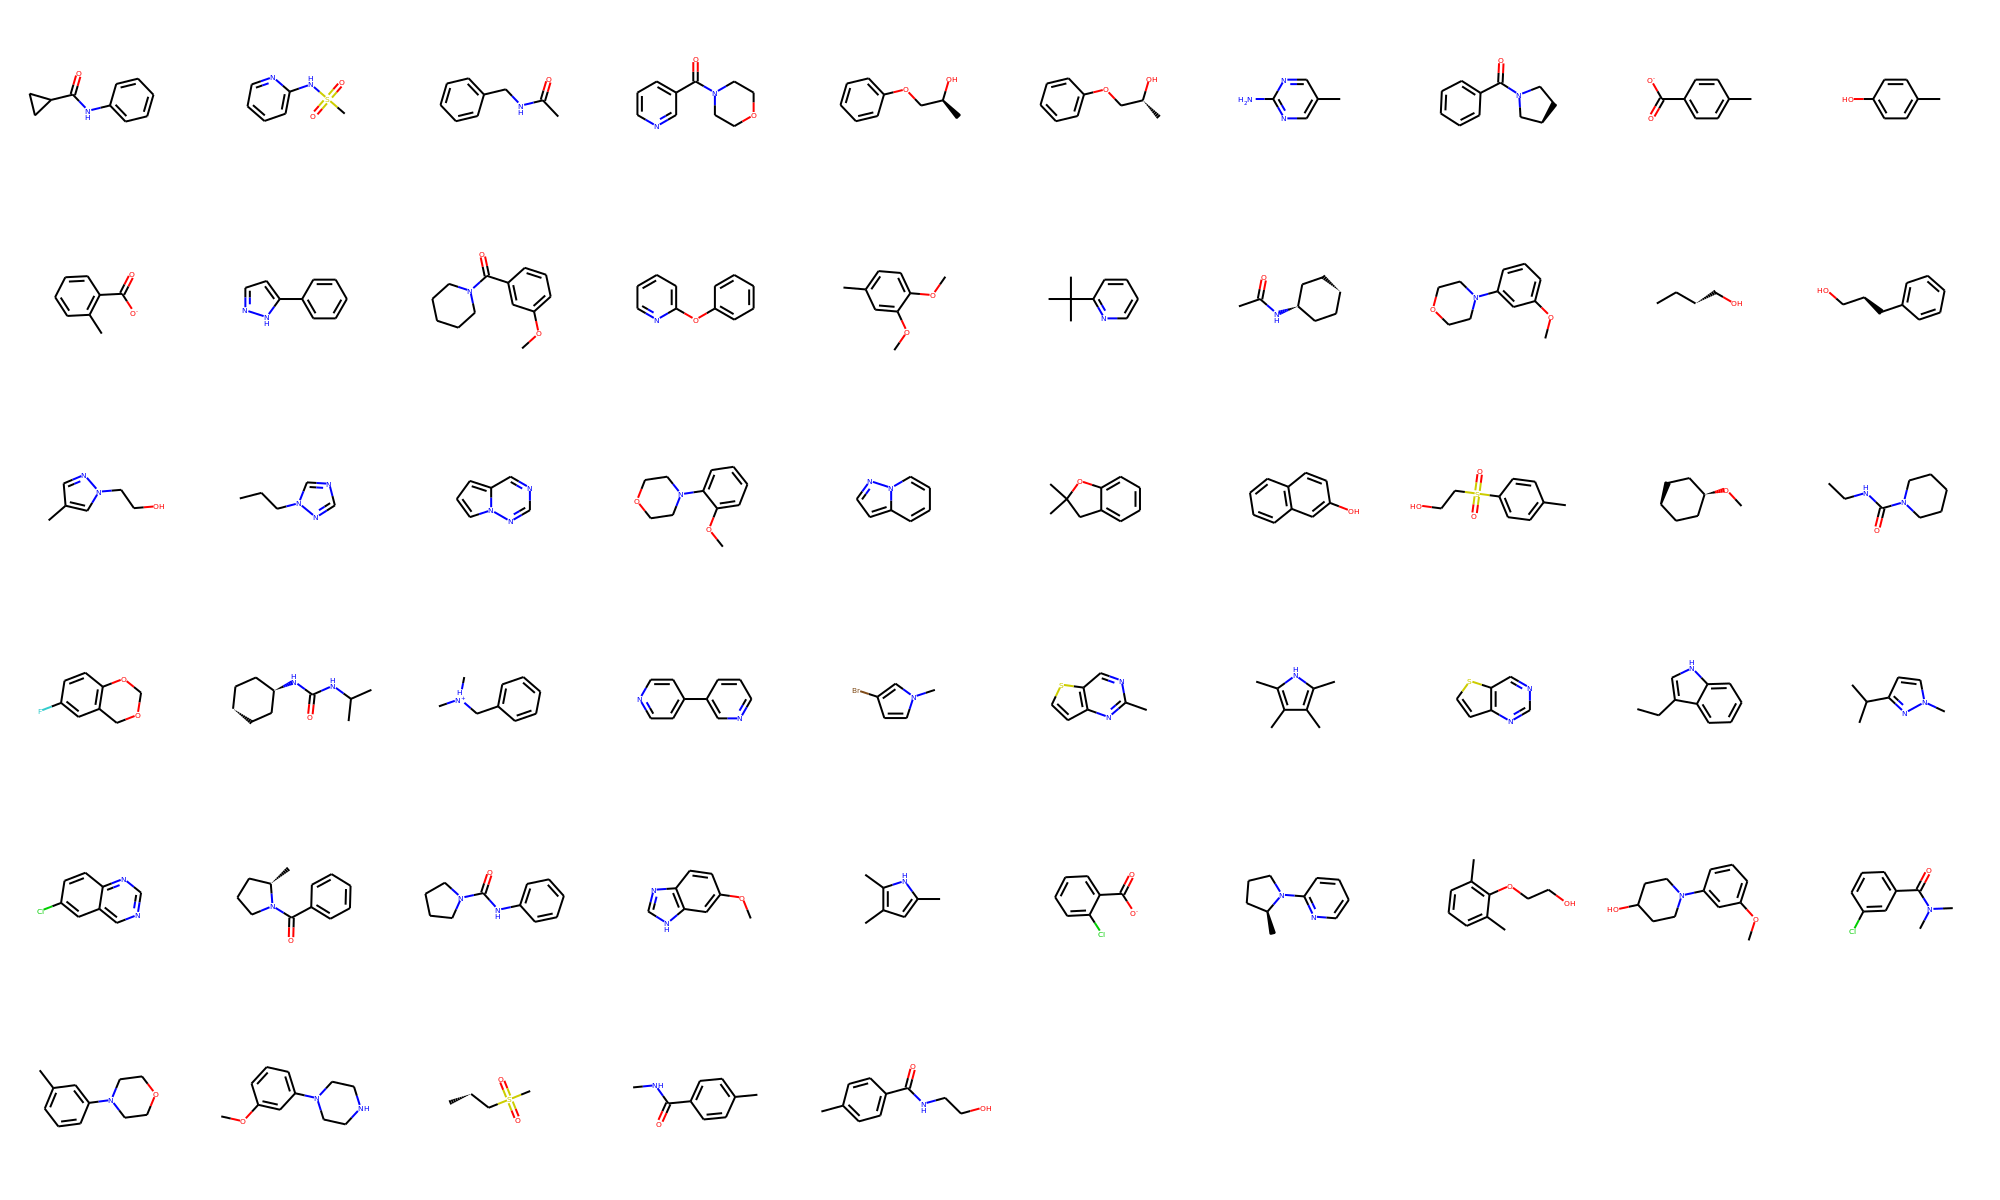

In [35]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["SE"][fragment_library["SE"]["retro_count"]==0].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["SE"][fragment_library["SE"]["retro_count"]==0].ROMol))
)

Rejected fragments

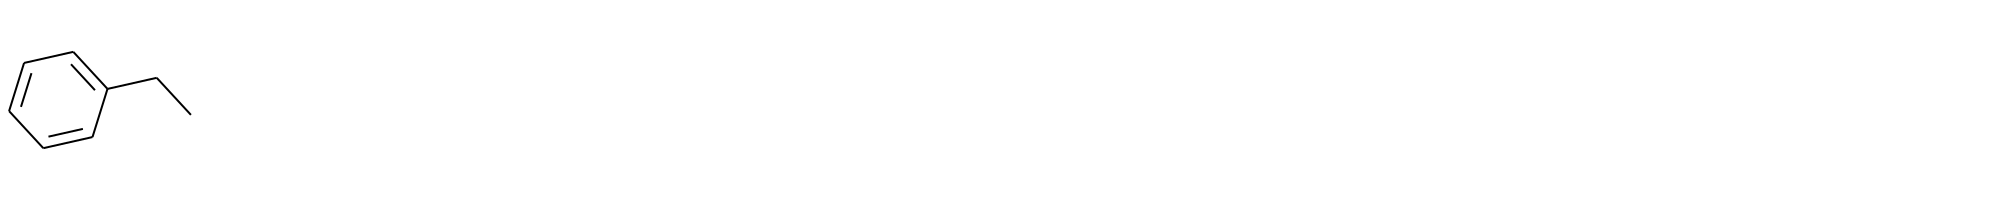

In [36]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["SE"][fragment_library["SE"]["retro_count"]==max(fragment_library["SE"]["retro_count"])].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["SE"][fragment_library["SE"]["retro_count"]==0].ROMol))
)

#### 5.3.4 Gate Area Pocket (GA)

Accepted fragments

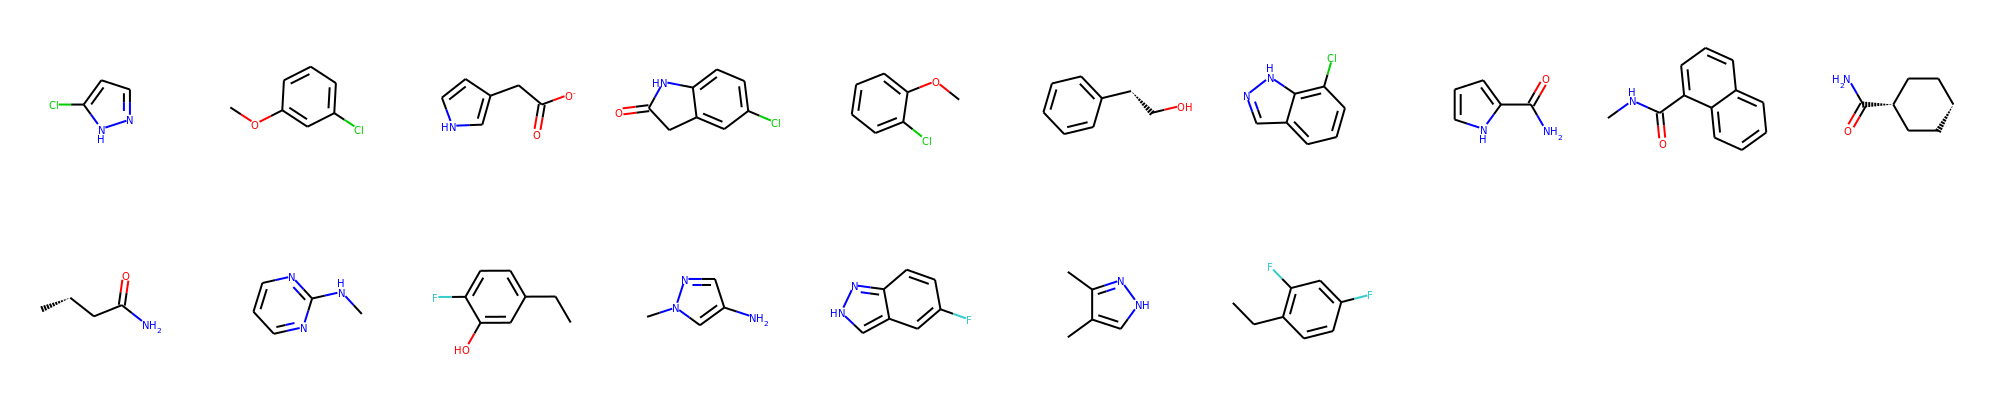

In [37]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["GA"][fragment_library["GA"]["retro_count"]==0].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["GA"][fragment_library["GA"]["retro_count"]==0].ROMol))
)

Rejected fragments

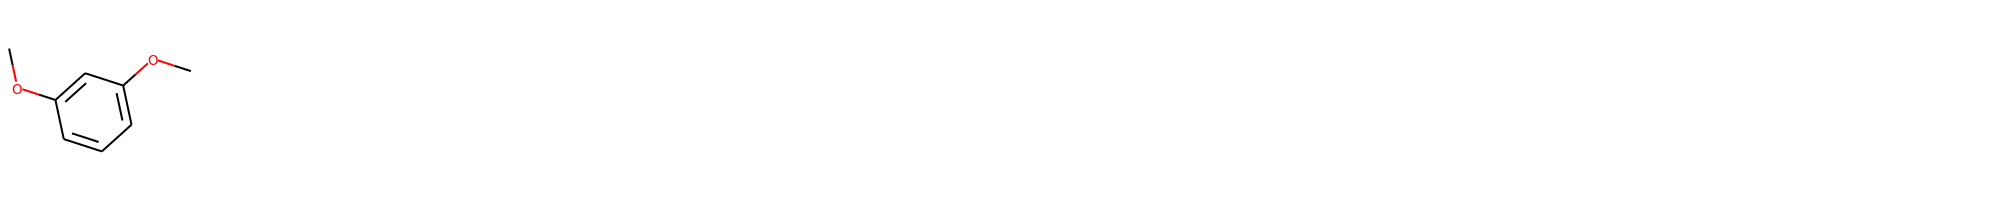

In [38]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["GA"][fragment_library["GA"]["retro_count"]==max(fragment_library["GA"]["retro_count"])].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["GA"][fragment_library["GA"]["retro_count"]==0].ROMol))
)

#### 5.3.5 Back Pocket 1 (B1)

Accepted fragments

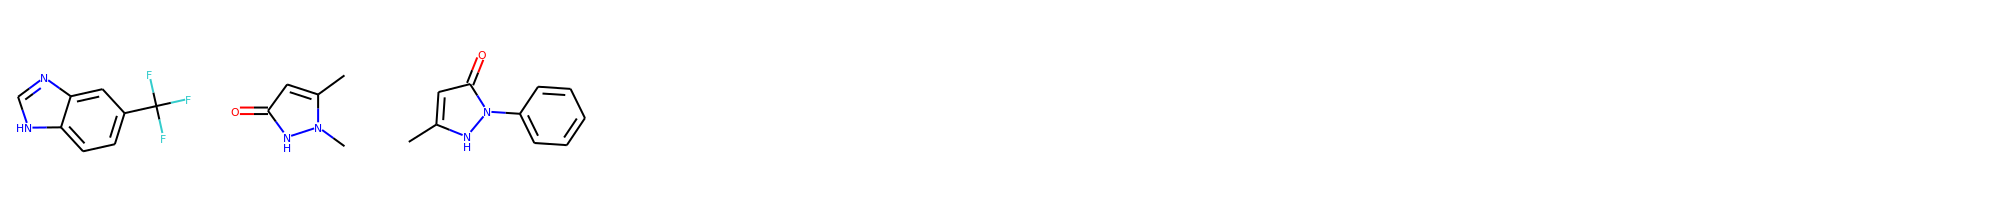

In [39]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["B1"][fragment_library["B1"]["retro_count"]==0].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["B1"][fragment_library["B1"]["retro_count"]==0].ROMol))
)

Rejected fragments

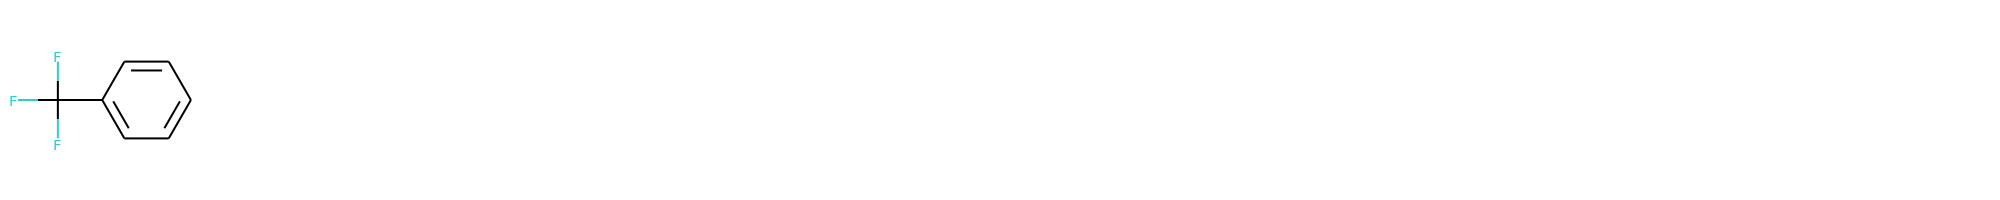

In [40]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["B1"][fragment_library["B1"]["retro_count"]==max(fragment_library["B1"]["retro_count"])].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["B1"][fragment_library["B1"]["retro_count"]==0].ROMol))
)

#### 5.3.6 Back Pocket 2 (B2)

Accepted fragments

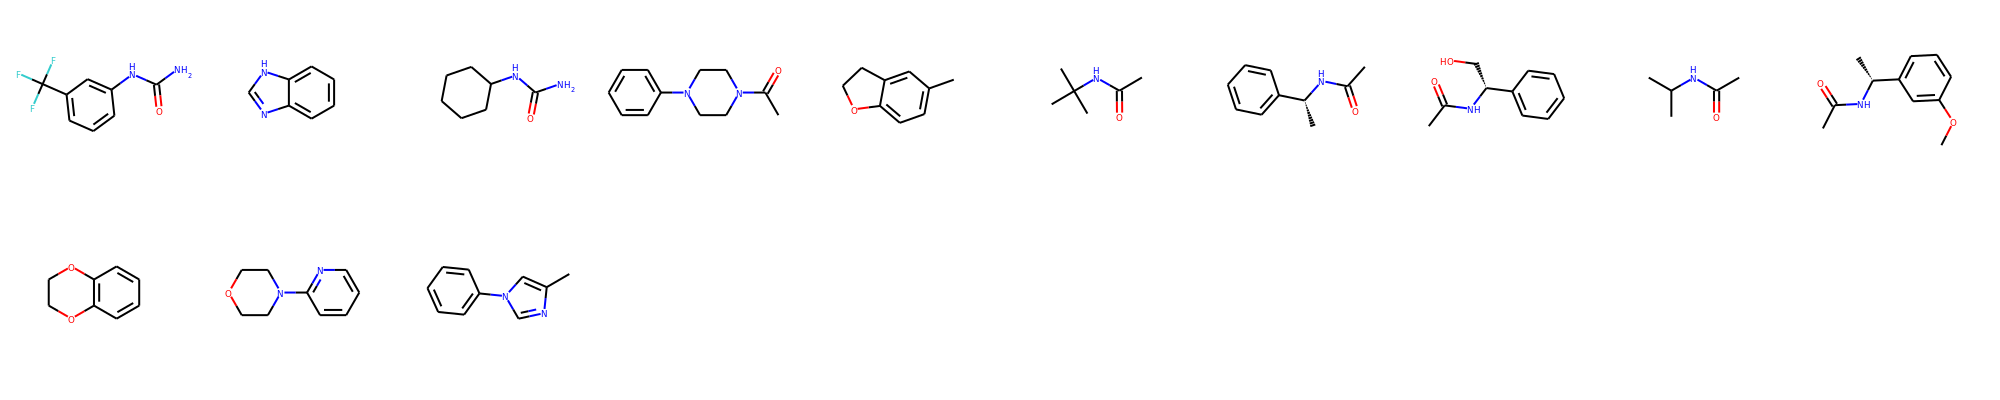

In [41]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["B2"][fragment_library["B2"]["retro_count"]==0].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["B2"][fragment_library["B2"]["retro_count"]==0].ROMol))
)

Rejected fragments

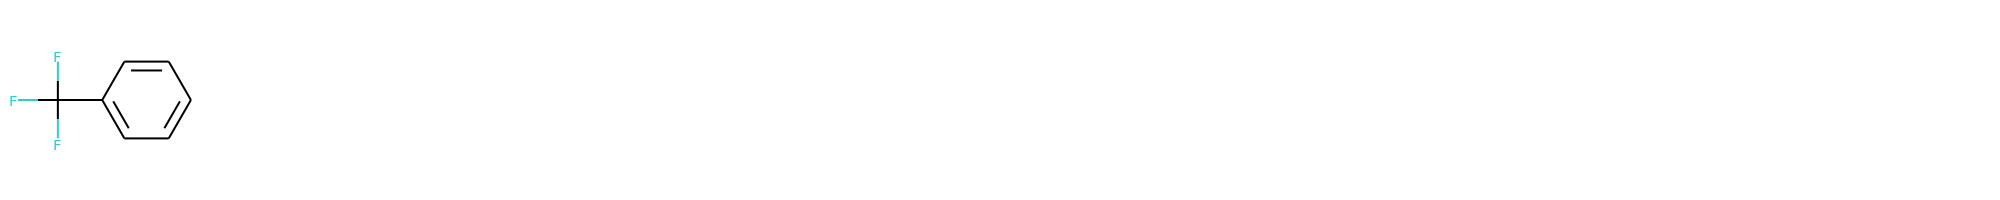

In [42]:
Draw.MolsToGridImage(
    pd.Series(fragment_library["B2"][fragment_library["B2"]["retro_count"]==max(fragment_library["B2"]["retro_count"])].ROMol),
    molsPerRow=10,
    maxMols=len(pd.Series(fragment_library["B2"][fragment_library["B2"]["retro_count"]==0].ROMol))
)